## Importar librerias y cargar datos

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Estilos generales
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")

# Cargar datos procesados
df = pd.read_csv("../data/processed/world_bank_indicators.csv")

# Excluir Argentina del análisis
df = df[df['country'] != 'Argentina']

# Ver primeros registros
df.head()


,year,value,country,indicator
0,2024,4.722256,Mexico,inflation
1,2023,5.527961,Mexico,inflation
2,2022,7.896276,Mexico,inflation
3,2021,5.689208,Mexico,inflation
4,2020,3.396834,Mexico,inflation


## Revisar estructura general

In [9]:
# Info general
df.info()

# Revisar valores únicos
print("Indicadores:", df['indicator'].unique())
print("Países:", df['country'].unique())


<class 'pandas.core.frame.DataFrame'>
Index: 1316 entries, 0 to 1315
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       1316 non-null   int64  
 1   value      1316 non-null   float64
 2   country    1316 non-null   object 
 3   indicator  1316 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 51.4+ KB
Indicadores: ['inflation' 'gdp_growth' 'current_account' 'external_debt'
 'reserves_months']
Países: ['Mexico' 'Brazil' 'Colombia' 'Chile' 'Peru']


## Verificar valores nulos

In [10]:
# Datos faltantes
df.isna().sum()

# Registros por país e indicador
df_grouped = df.groupby(['country', 'indicator'])['year'].count().unstack()
df_grouped


indicator,current_account,external_debt,gdp_growth,inflation,reserves_months
country,,,,,
Brazil,49.0,54.0,63.0,44.0,49.0
Chile,49.0,NaN,63.0,54.0,49.0
Colombia,56.0,54.0,63.0,65.0,56.0
Mexico,45.0,54.0,63.0,65.0,45.0
Peru,47.0,54.0,63.0,65.0,47.0


## Visualizacion de las series temporales

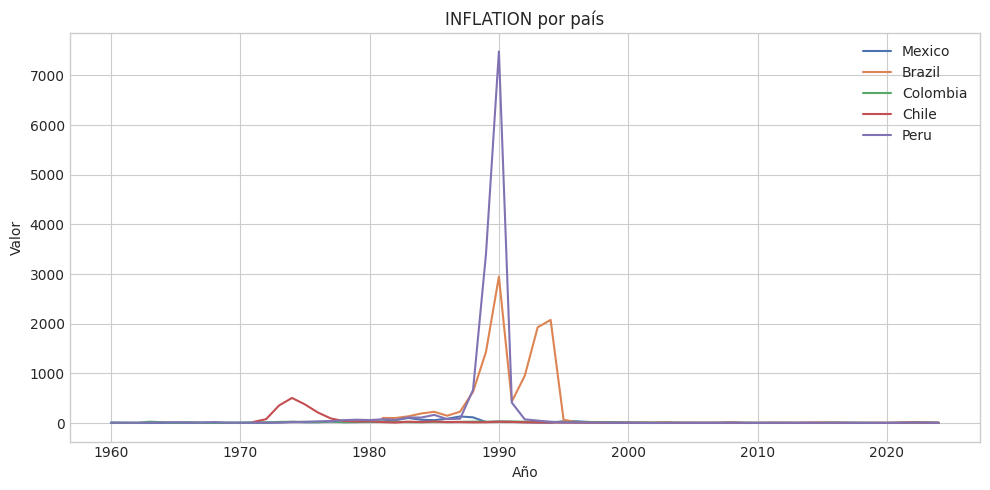

In [11]:
# Función de línea temporal por indicador
def plot_time_series(indicador):
    plt.figure(figsize=(10, 5))
    for pais in df['country'].unique():
        sub = df[(df['indicator'] == indicador) & (df['country'] == pais)]
        if sub.empty:
            print(f"No hay datos para {pais} - {indicador}")
            continue
        sub = sub.sort_values('year')
        plt.plot(sub['year'], sub['value'], label=pais)
    plt.title(f'{indicador.upper()} por país')
    plt.xlabel('Año')
    plt.ylabel('Valor')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Ejemplo: inflación
plot_time_series('inflation')


## Buscar el año más reciente con múltiples indicadores disponibles

In [14]:
# Ver cantidad de datos por año e indicador
pivot_check = df.dropna().groupby(['year', 'indicator']).size().unstack().fillna(0)
pivot_check.tail(10)


indicator,current_account,external_debt,gdp_growth,inflation,reserves_months
year,,,,,
2015,5.0,4.0,5.0,5.0,5.0
2016,5.0,4.0,5.0,5.0,5.0
2017,5.0,4.0,5.0,5.0,5.0
2018,5.0,4.0,5.0,5.0,5.0
2019,5.0,4.0,5.0,5.0,5.0
2020,5.0,4.0,5.0,5.0,5.0
2021,5.0,4.0,5.0,5.0,5.0
2022,5.0,4.0,5.0,5.0,5.0
2023,5.0,4.0,5.0,5.0,5.0


## Buscar que paises cuentan con datos para todos los indicadores

In [16]:
df_missing = df[
    (df['indicator'] == 'external_debt') &
    (df['year'].astype(int).between(2019, 2023))  # o 2015-2023 según lo que decidas
]

df_missing.pivot_table(index='year', columns='country', values='value', aggfunc='first')


country,Brazil,Colombia,Mexico,Peru
year,,,,
2019,31.196414,43.985056,48.716919,29.191603
2020,38.007452,58.160561,56.834966,37.514998
2021,35.311832,54.912358,46.896765,41.564918
2022,30.532862,54.576805,40.930951,38.660286
2023,28.803139,54.898005,34.160144,35.540431


## Distribuciones y correlaciones

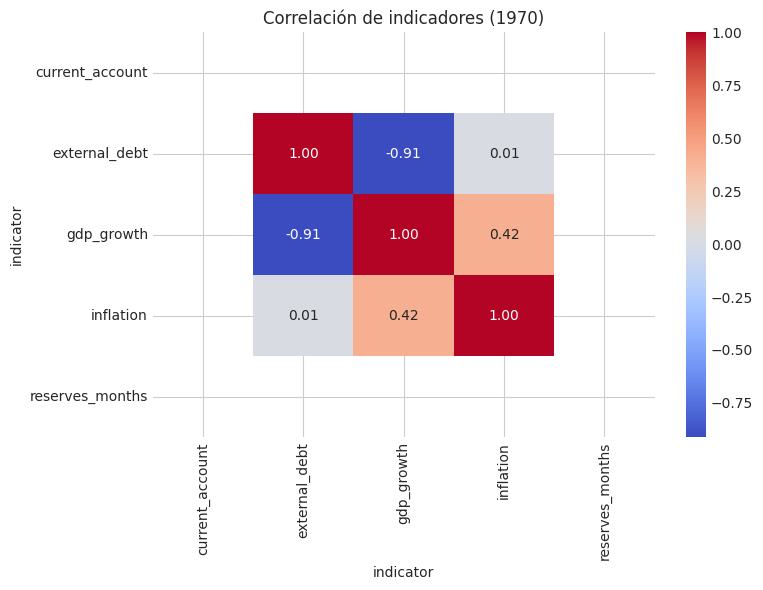

In [17]:
# Asegurarse de que el campo 'year' sea entero
df['year'] = df['year'].astype(int)

# Excluir Chile del análisis
df_filtered = df[df['country'] != 'Chile']

# Encontrar el año más reciente con múltiples indicadores disponibles
year_counts = df_filtered.dropna().groupby('year')['indicator'].nunique()
latest_valid_year = year_counts[year_counts > 1].idxmax()

# Filtrar los datos para ese año
df_latest = df_filtered[df_filtered['year'] == latest_valid_year]
df_latest = df_latest.pivot(index='country', columns='indicator', values='value')

# Validación final antes de graficar
if df_latest.shape[1] < 2:
    print(f"Solo hay un indicador en {latest_valid_year}. No se puede calcular correlación.")
elif df_latest.empty:
    print(f"No hay datos válidos para el año {latest_valid_year}.")
else:
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_latest.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f'Correlación de indicadores ({latest_valid_year})')
    plt.tight_layout()
    plt.show()



## Construir base_index.csv (promedio 2019-2023) excluyendo a Chile

In [18]:
# Filtrar datos para los años 2019-2023 y excluir Chile
df['year'] = df['year'].astype(int)
df_5y = df[
    df['year'].between(2019, 2023) &
    (df['country'] != 'Chile')
]

# Calcular promedio 5 años por país e indicador
df_base = df_5y.groupby(['country', 'indicator'])['value'].mean().reset_index()

# Guardar CSV base para el índice compuesto
df_base.to_csv("../data/processed/base_index.csv", index=False)
print("Archivo base_index.csv generado (sin Chile, años 2019–2023)")


Archivo base_index.csv generado (sin Chile, años 2019–2023)
